# Flatiron Health aNSCLC: MICE

**OBJECTIVE: Impute missing variables in the training dataset using multiple imputation chained equations (MICE). Five non-missing training sets will be construced using MICE along with 5 test sets. A gradient boosting model will be fit to each training dataset and a test set AUC will be calculated. The 1 year AUCs from the test set will be pooled to get a final estimate.** 

**BACKGROUND: The variables with the most missingness at time of advanced diagnosis are ECOG (50%), labs (30%), and changes in weight (11%). These three variables have high predictive value in our models. Up until this point, missingness has been handled by making "unknown" a level in the ECOG variable and imputing median for lab values and weight loss. While this imputation strategy is simple and fast, it likely understimates the variance of variables and disturb relations between variables when the data is not missing completely at random.** 

**Variables that will be imputed with MICE:** 
1. **ECOG (48% missing)**
2. **BMI (15% missing)**
3. **Weight (14% missing)**
4. **Percent change in weight and weight slope (11% missing)**
5. **Labs at time of advanced diagnosis (30% missing)**
6. **Subset of summary labs (40% missing)**

**Five complete training sets will be imputed using the Python package "miceforest" which uses lightgbm as a backend. Five complete test sets will also be imputed from the final model used to impute the training set values. All existing variables including outcome variables like death status and time until event will be utilized to aid in the imputations. In addition, auxillary variables such as receipt of treatment, weight and BMI at 3 months, and labs at 3 months will be created to augment imputations.**   

**After complete training and test sets are constructed, a gradient boosting survival model will be built for each training set in the same fashion as in the crude imputation notebook. Final test AUCs will be pooled using Rubin's rules.**

**OUTLINE:**
1. **Building auxillary variables** 
2. **Performing MICE on training and test sets** 
3. **Building gradient boosting models on imputed datasets**
4. **Pooling results**

## 1. Building auxillary varibles 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

### 1.1 Preprocessing

In [3]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(54786, 54786)

In [4]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(13697, 13697)

In [5]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(68483, 68483)

### 1.2 Treatment 

**Add indicator variables for first, second, and third line treatment. Treatment will be characterized as receipt of FDA approved targeted agent, immunotherapy agenet, or chemotherapy (clinical study drug included).** 

In [6]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [7]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(df['PatientID'])]

In [8]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [9]:
immunotherapy = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab']

In [10]:
chemotherapy = [
    'Carboplatin',
    'Cisplatin',
    'Docetaxel',
    'Paclitaxel',
    'Amivantamab',
    'Bevacizumab',
    'Doxorubicin',
    'Everolimus',
    'Etoposide',
    'Gemcitabine',
    'Methotrexate',
    'Necitumumab',
    'Pemetrexed',
    'Ramucirumab',
    'Vinorelbine',
    'Clinical Study Drug']

In [11]:
line_therapy_1 = line_therapy.query('LineNumber == 1')
line_therapy_2 = line_therapy.query('LineNumber == 2')
line_therapy_3 = line_therapy.query('LineNumber == 3')

In [12]:
line_therapy_1.loc[:, 'targeted_1'] = np.where(
    line_therapy_1['LineName'].str.contains('|'.join(targeted)), 1, 0)

line_therapy_2.loc[:, 'targeted_2'] = np.where(
    line_therapy_2['LineName'].str.contains('|'.join(targeted)), 1, 0)

line_therapy_3.loc[:, 'targeted_3'] = np.where(
    line_therapy_3['LineName'].str.contains('|'.join(targeted)), 1, 0)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [13]:
line_therapy_1.loc[:, 'io_1'] = np.where(
    line_therapy_1['LineName'].str.contains('|'.join(immunotherapy)), 1, 0)

line_therapy_2.loc[:, 'io_2'] = np.where(
    line_therapy_2['LineName'].str.contains('|'.join(immunotherapy)), 1, 0)

line_therapy_3.loc[:, 'io_3'] = np.where(
    line_therapy_3['LineName'].str.contains('|'.join(immunotherapy)), 1, 0)

In [14]:
line_therapy_1.loc[:, 'chemo_1'] = np.where(
    line_therapy_1['LineName'].str.contains('|'.join(chemotherapy)), 1, 0)

line_therapy_2.loc[:, 'chemo_2'] = np.where(
    line_therapy_2['LineName'].str.contains('|'.join(chemotherapy)), 1, 0)

line_therapy_3.loc[:, 'chemo_3'] = np.where(
    line_therapy_3['LineName'].str.contains('|'.join(chemotherapy)), 1, 0)

In [15]:
line_therapy_1_n = line_therapy_1.groupby('PatientID')['targeted_1', 'io_1', 'chemo_1'].sum()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [16]:
# Because of maintenance line is also listed as first line, patients can have chemo or immunotherapy twice 
line_therapy_1_final = (
    line_therapy_1_n
    .mask(line_therapy_1_n > 1, 1)
    .reset_index())

In [17]:
line_therapy_2 = line_therapy_2[['PatientID', 'targeted_2', 'io_2', 'chemo_2']]

line_therapy_3 = line_therapy_3[['PatientID', 'targeted_3', 'io_3', 'chemo_3']]

In [18]:
df = pd.merge(df, line_therapy_1_final, on = 'PatientID', how = 'outer')

In [19]:
df[['targeted_1', 'io_1', 'chemo_1']] = df[['targeted_1', 'io_1', 'chemo_1']].fillna(value = 0)

In [20]:
df = pd.merge(df, line_therapy_2, on = 'PatientID', how = 'outer')

In [21]:
df[['targeted_2', 'io_2', 'chemo_2']] = df[['targeted_2', 'io_2', 'chemo_2']].fillna(value = 0)

In [22]:
df = pd.merge(df, line_therapy_3, on = 'PatientID', how = 'outer')

In [23]:
df[['targeted_3', 'io_3', 'chemo_3']] = df[['targeted_3', 'io_3', 'chemo_3']].fillna(value = 0)

In [24]:
df.shape

(68483, 222)

In [25]:
%whos DataFrame

Variable               Type         Data/Info
---------------------------------------------
df                     DataFrame               PatientID Prac<...>68483 rows x 222 columns]
line_therapy           DataFrame               PatientID     <...>n[95320 rows x 9 columns]
line_therapy_1         DataFrame               PatientID     <...>[57330 rows x 12 columns]
line_therapy_1_final   DataFrame               PatientID  tar<...>n[49820 rows x 4 columns]
line_therapy_1_n       DataFrame                   targeted_1<...>n[49820 rows x 3 columns]
line_therapy_2         DataFrame               PatientID  tar<...>n[21733 rows x 4 columns]
line_therapy_3         DataFrame               PatientID  tar<...>\n[9329 rows x 4 columns]
test                   DataFrame               PatientID Prac<...>13697 rows x 213 columns]
train                  DataFrame               PatientID Prac<...>54786 rows x 213 columns]


In [26]:
del line_therapy
del line_therapy_1
del line_therapy_1_final
del line_therapy_1_n
del line_therapy_2
del line_therapy_3

### 1.3 Weight

In [27]:
vitals = pd.read_csv('Vitals.csv')

vitals = vitals[vitals['PatientID'].isin(df['PatientID'])]

In [28]:
enhanced_adv = enhanced_adv = pd.read_csv('Enhanced_AdvancedNSCLC.csv')

enhanced_adv = enhanced_adv[enhanced_adv['PatientID'].isin(df['PatientID'])]
                                                              
enhanced_adv.loc[:, 'AdvancedDiagnosisDate'] = pd.to_datetime(enhanced_adv['AdvancedDiagnosisDate'])

enhanced_adv = enhanced_adv.rename(columns = {'AdvancedDiagnosisDate': 'adv_date'})

#### Weight and BMI

In [29]:
# Create weight dataframe; remove weight values that are empty or equal to zero.
weight = (
    vitals
    .query('Test == "body weight"')
    .filter(items = ['PatientID', 'TestDate', 'TestResultCleaned'])
    .rename(columns = {'TestResultCleaned': 'weight'})
    .dropna(subset = ['weight'])
    .query('weight != 0')
)

In [30]:
weight.loc[:, 'TestDate'] = pd.to_datetime(weight['TestDate'])

In [31]:
weight = pd.merge(weight, enhanced_adv[['PatientID', 'adv_date']], on = 'PatientID', how = 'left')

In [32]:
# Weight elgibliity window is -60 to +60 from 3 months after advanced diagnosis. 
weight_win_bmi = (
    weight
    .assign(weight_date_diff = ((weight['TestDate'] - (weight['adv_date'] + pd.DateOffset(days = 90))).dt.days))
    .query('weight_date_diff >= -60 and weight_date_diff <= 60')
)

In [33]:
weight_win_bmi.loc[:, 'weight_date_diff'] = weight_win_bmi['weight_date_diff'].abs()

In [34]:
# Select weight closest to +90 from advanced diagnosis; lowest weight selected in the event of two weights on same day or equidistant. 
weight_bmi_wide = (
    weight_win_bmi
    .sort_values(by = ['PatientID', 'weight_date_diff', 'weight'], ascending = [True, True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'weight'])
    .rename(columns = {'weight': 'weight_90'})
)

In [35]:
# Dataframe of average height for each patient. 
height_avg = (
    vitals
    .query('Test == "body height"')
    .filter(items = ['PatientID', 'TestResultCleaned'])
    .groupby('PatientID')['TestResultCleaned'].mean()
    .to_frame()
    .reset_index()
    .rename(columns = {'TestResultCleaned': 'height_avg'})
)

In [36]:
weight_bmi_wide = pd.merge(weight_bmi_wide, height_avg, on = 'PatientID', how = 'left')

In [37]:
# Create BMI column. 
weight_bmi_wide = (
    weight_bmi_wide
    .assign(bmi_90 = lambda x: (x['weight_90']/(x['height_avg']*x['height_avg']))*10000)
    .drop(columns = ['height_avg'])
)

In [38]:
df = pd.merge(df, weight_bmi_wide, on = 'PatientID', how = 'outer')

#### Percent change in weight 

In [39]:
# Select elgbility window of -90 to +180 days from advanced diagnosis.
weight_win_summary = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['adv_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 180')
)

In [40]:
# Select patients with more than 1 weight recording within elgibility window.
weight_win_summary = weight_win_summary[weight_win_summary.duplicated(subset = ['PatientID'], keep = False)]

In [41]:
# Select weight from the earliest time within elgibility window. 
weight_tmin = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmin()]

In [42]:
# Select weight from the latest time within elgibility window. 
weight_tmax = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmax()]

In [43]:
# Combine above two dataframes and sort from earliest recorded weight to latest recorded weight for each patient. 
weight_tcomb = (
    pd.concat([weight_tmin, weight_tmax])
    .sort_values(by = ['PatientID', 'weight_date_diff'], ascending = True)
)

In [44]:
weight_tcomb.loc[:, 'weight_pct_6m'] = weight_tcomb.groupby('PatientID')['weight'].pct_change()

In [45]:
# Drop empty rows for weight_pct_change.
weight_pct_wide = (
    weight_tcomb
    .dropna(subset = ['weight_pct_6m'])
    .filter(items = ['PatientID', 'weight_pct_6m'])
)

In [46]:
df = pd.merge(df, weight_pct_wide, on = 'PatientID', how = 'outer')

#### Slope of weight 

In [47]:
import datetime as dt
from scipy.stats import linregress 

In [48]:
weight_win_summary.loc[:, 'date_ordinal'] = weight_win_summary['TestDate'].map(dt.datetime.toordinal)

In [49]:
# Dataframe of slope for weight recordings within window period (kg/day).
weight_slope_wide = (
    weight_win_summary
    .groupby('PatientID')
    .apply(lambda x: pd.Series(linregress(x['date_ordinal'], x['weight'])))
    .rename(columns = {0: 'weight_slope_6m'})
    .reset_index()
    .filter(items = ['PatientID', 'weight_slope_6m'])) 

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


In [50]:
df = pd.merge(df, weight_slope_wide, on = 'PatientID', how = 'outer')

In [51]:
df.shape

(68483, 226)

In [52]:
%whos DataFrame

Variable             Type         Data/Info
-------------------------------------------
df                   DataFrame               PatientID Prac<...>68483 rows x 226 columns]
enhanced_adv         DataFrame               PatientID Diag<...>n[68483 rows x 6 columns]
height_avg           DataFrame               PatientID  hei<...>n[67572 rows x 2 columns]
test                 DataFrame               PatientID Prac<...>13697 rows x 213 columns]
train                DataFrame               PatientID Prac<...>54786 rows x 213 columns]
vitals               DataFrame                  PatientID  <...>814491 rows x 15 columns]
weight               DataFrame                 PatientID   <...>1666797 rows x 4 columns]
weight_bmi_wide      DataFrame               PatientID  wei<...>n[52105 rows x 3 columns]
weight_pct_wide      DataFrame                 PatientID  w<...>n[57678 rows x 2 columns]
weight_slope_wide    DataFrame               PatientID  wei<...>n[57678 rows x 2 columns]
weight_tcomb

In [53]:
del height_avg
del vitals
del weight
del weight_bmi_wide
del weight_pct_wide
del weight_slope_wide
del weight_tcomb
del weight_tmax
del weight_tmin
del weight_win_bmi
del weight_win_summary

### 1.4 Static labs 

In [54]:
lab = pd.read_csv('Lab.csv')

In [55]:
lab = lab[lab['PatientID'].isin(df['PatientID'])]

In [56]:
lab = pd.merge(lab, enhanced_adv[['PatientID', 'adv_date']], on = 'PatientID', how = 'left')

In [57]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate'], errors = 'coerce') 

In [58]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "26464-8") |
    (lab['LOINC'] == "6690-2") |
    (lab['LOINC'] == "26499-4") |
    (lab['LOINC'] == "751-8") |
    (lab['LOINC'] == "30451-9") |
    (lab['LOINC'] == "753-4") |
    (lab['LOINC'] == "1751-7") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2") |
    (lab['LOINC'] == "2947-0") |
    (lab['LOINC'] == "2951-2") |
    (lab['LOINC'] == "1963-8") |
    (lab['LOINC'] == "1959-6") |
    (lab['LOINC'] == "14627-4") |
    (lab['LOINC'] == "1960-4") |
    (lab['LOINC'] == "2028-9") |
    (lab['LOINC'] == "17861-6") |
    (lab['LOINC'] == "49765-1") |
    (lab['LOINC'] == "1920-8") |
    (lab['LOINC'] == "1742-6") | 
    (lab['LOINC'] == "1743-4") |
    (lab['LOINC'] == "1744-2") |
    (lab['LOINC'] == "26515-7") | 
    (lab['LOINC'] == "777-3") |
    (lab['LOINC'] == "778-1") |
    (lab['LOINC'] == "49497-1") | 
    (lab['LOINC'] == "6298-4") |
    (lab['LOINC'] == "2823-3") |
    (lab['LOINC'] == "2075-0") | 
    (lab['LOINC'] == "3094-0") | 
    (lab['LOINC'] == "6768-6")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'adv_date'])
)

In [59]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '26464-8') | (lab_core['LOINC'] == '6690-2')), 
    ((lab_core['LOINC'] == '26499-4') | (lab_core['LOINC'] == '751-8') | (lab_core['LOINC'] == '30451-9') | (lab_core['LOINC'] == '753-4')),
    (lab_core['LOINC'] == '1751-7'),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2')),
    ((lab_core['LOINC'] == '2947-0') | (lab_core['LOINC'] == '2951-2')),
    ((lab_core['LOINC'] == '1963-8') | (lab_core['LOINC'] == '1959-6') | (lab_core['LOINC'] == '14627-4') | (lab_core['LOINC'] == '1960-4') | (lab_core['LOINC'] == '2028-9')),
    ((lab_core['LOINC'] == '17861-6') | (lab_core['LOINC'] == '49765-1')),
    (lab_core['LOINC'] == '1920-8'),
    ((lab_core['LOINC'] == '1742-6') | (lab_core['LOINC'] == '1743-4') | (lab_core['LOINC'] == '1744-2')),
    ((lab_core['LOINC'] == '26515-7') | (lab_core['LOINC'] == '777-3') | (lab_core['LOINC'] == '778-1') | (lab_core['LOINC'] == '49497-1')),
    ((lab_core['LOINC'] == '6298-4') | (lab_core['LOINC'] == '2823-3')),
    (lab_core['LOINC'] == '2075-0'), 
    (lab_core['LOINC'] == '3094-0'),
    (lab_core['LOINC'] == '6768-6')]

choices = ['creatinine', 
           'hemoglobin', 
           'wbc', 
           'neutrophil_count',  
           'albumin', 
           'total_bilirubin', 
           'sodium', 
           'bicarb',
           'calcium',
           'ast', 
           'alt',
           'platelet',
           'potassium', 
           'chloride',
           'bun',
           'alp']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [60]:
lab_core = (
    lab_core
    .dropna(subset = ['TestResultCleaned'])
)

In [61]:
conditions = [
    ((lab_core['lab_name'] == 'wbc') | (lab_core['lab_name'] == 'neutrophil_count') | (lab_core['lab_name'] == 'platelet')) & 
    (lab_core['TestUnits'] == '10*3/L'),
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] * 1000000,
           lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [62]:
# Elgibliity window is +30 to +150 from advanced diagnosis. 
lab_core_win = (
    lab_core
    .assign(lab_date_diff = ((lab_core['ResultDate'] - (lab_core['adv_date'] + pd.DateOffset(days = 90))).dt.days))
    .query('lab_date_diff >= -60 and lab_date_diff <= 60')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'adv_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [63]:
lab_core_win.loc[:, 'lab_date_diff'] = lab_core_win['lab_date_diff'].abs()

In [64]:
# Select lab closest to date of advanced diagnosis and pivot to a wide table. 
lab_90_wide = (
    lab_core_win
    .loc[lab_core_win.groupby(['PatientID', 'lab_name'])['lab_date_diff'].idxmin()]
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_90',
        'creatinine': 'creatinine_90',
        'hemoglobin': 'hemoglobin_90',
        'neutrophil_count': 'neutrophil_count_90',
        'total_bilirubin': 'total_bilirubin_90',
        'wbc': 'wbc_90',
        'sodium': 'sodium_90', 
        'bicarb': 'bicarb_90',
        'calcium': 'calcium_90',
        'ast': 'ast_90', 
        'alt': 'alt_90',
        'platelet': 'platelet_90',
        'potassium': 'potassium_90',
        'chloride': 'chloride_90',
        'bun': 'bun_90',
        'alp': 'alp_90'})
)

lab_90_wide.columns.name = None

In [65]:
df = pd.merge(df, lab_90_wide, on = 'PatientID', how = 'outer')

In [66]:
df.shape

(68483, 242)

### 1.5 Summary labs

In [67]:
# Elgibility window is negative infinity to +150 from advanced diagnosis. 
lab_core_win_summ = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['adv_date']).dt.days)
    .query('lab_date_diff <= 150')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'adv_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [68]:
# Pivot table of maximum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_max_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].max()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['alp', 'alt', 'ast', 'calcium', 'creatinine', 'total_bilirubin', 'wbc'])
    .reset_index()
    .rename(columns = {
        'alp': 'alp_max_f',
        'alt': 'alt_max_f',
        'ast': 'ast_max_f',
        'calcium': 'calcium_max_f',
        'creatinine': 'creatinine_max_f',
        'total_bilirubin': 'total_bilirubin_max_f',
        'wbc': 'wbc_max_f'})
)

lab_max_wide.columns.name = None

In [69]:
# Pivot table of minimum values for core labs during elgibility period of -inf to +150 days from advanced diagnosis. 
lab_min_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].min()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .filter(items = ['albumin', 'bicarb', 'hemoglobin', 'platelet', 'sodium', 'wbc'])
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_min_f',
        'bicarb': 'bicarb_min_f',
        'hemoglobin': 'hemoglobin_min_f',
        'platelet': 'platelet_min_f',
        'sodium': 'sodium_min_f', 
        'wbc': 'wbc_min_f'})
)

lab_min_wide.columns.name = None

In [70]:
df = pd.merge(df, lab_max_wide, on = 'PatientID', how = 'outer')

In [71]:
df.shape

(68483, 249)

In [72]:
df = pd.merge(df, lab_min_wide, on = 'PatientID', how = 'outer')

In [73]:
df.shape

(68483, 255)

In [74]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
df                  DataFrame               PatientID Prac<...>68483 rows x 255 columns]
enhanced_adv        DataFrame               PatientID Diag<...>n[68483 rows x 6 columns]
lab                 DataFrame                  PatientID  <...>492037 rows x 17 columns]
lab_90_wide         DataFrame               PatientID  alb<...>[50538 rows x 17 columns]
lab_core            DataFrame                  PatientID R<...>287133 rows x 11 columns]
lab_core_win        DataFrame                  PatientID R<...>4311889 rows x 7 columns]
lab_core_win_summ   DataFrame                  PatientID R<...>8342666 rows x 7 columns]
lab_max_wide        DataFrame               PatientID  alp<...>n[59845 rows x 8 columns]
lab_min_wide        DataFrame               PatientID  alb<...>n[59845 rows x 7 columns]
test                DataFrame               PatientID Prac<...>13697 rows x 213 columns]
train               Data

In [75]:
del enhanced_adv
del lab
del lab_90_wide
del lab_core
del lab_core_win
del lab_core_win_summ
del lab_max_wide
del lab_min_wide

### 1.6 Replacing 'unknown' with np.nan for variables of interest

In [76]:
df = df.replace({'stage': {'unknown': np.nan},
                 'ecog_diagnosis': {'unknown': np.nan}})

### 1.7 Dropping unwanted summary variables 

In [77]:
drop_labs = [
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'bicarb_max',
    'bun_max',
    'chloride_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'alp_min',
    'alt_min',
    'ast_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'neutrophil_count_min',
    'potassium_min',
    'total_bilirubin_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [78]:
df = df.drop(columns = drop_labs)

In [79]:
df.shape

(68483, 172)

In [80]:
df.loc[:, 'alp_max_na'] = np.where(df['alp_max'].isna(), 1, 0)
df.loc[:, 'alt_max_na'] = np.where(df['alt_max'].isna(), 1, 0)
df.loc[:, 'ast_max_na'] = np.where(df['ast_max'].isna(), 1, 0)
df.loc[:, 'calcium_max_na'] = np.where(df['calcium_max'].isna(), 1, 0)
df.loc[:, 'creatinine_max_na'] = np.where(df['creatinine_max'].isna(), 1, 0)
df.loc[:, 'total_bilirubin_max_na'] = np.where(df['total_bilirubin_max'].isna(), 1, 0)
df.loc[:, 'wbc_max_na'] = np.where(df['wbc_max'].isna(), 1, 0)
df.loc[:, 'albumin_min_na'] = np.where(df['albumin_min'].isna(), 1, 0)
df.loc[:, 'bicarb_min_na'] = np.where(df['bicarb_min'].isna(), 1, 0)
df.loc[:, 'hemoglobin_min_na'] = np.where(df['hemoglobin_min'].isna(), 1, 0)
df.loc[:, 'platelet_min_na'] = np.where(df['platelet_min'].isna(), 1, 0)
df.loc[:, 'sodium_min_na'] = np.where(df['sodium_min'].isna(), 1, 0)
df.loc[:, 'wbc_min_na'] = np.where(df['wbc_min'].isna(), 1, 0)

In [81]:
df.shape

(68483, 185)

In [82]:
df_mice = df

In [83]:
df_mice.to_csv('df_mice.csv', index = False, header = True)

### 1.8 Final processing

In [84]:
train_mice = df_mice[df_mice['PatientID'].isin(train['PatientID'])]
train_mice = train_mice.set_index('PatientID')

In [85]:
test_mice = df_mice[df_mice['PatientID'].isin(test['PatientID'])]
test_mice = test_mice.set_index('PatientID')

In [86]:
list(train_mice.select_dtypes(include = ['object']).columns)

['PracticeType',
 'gender',
 'race',
 'ethnicity',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'ecog_diagnosis']

In [87]:
to_be_categorical = list(train_mice.select_dtypes(include = ['object']).columns)

In [88]:
# Add adv_year to list of object variables which will be converted to categorical in below cell. 
to_be_categorical.append('adv_year')

In [89]:
# miceforest requires columns to be category or int/float, so object columns will be converted to category. 
for x in list(to_be_categorical):
    train_mice[x] = train_mice[x].astype('category')

In [90]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [91]:
# List of variable that have missing values which MICE will impute. 
list(train_mice.columns[train_mice.isnull().any()])

['stage',
 'ecog_diagnosis',
 'weight_diag',
 'bmi_diag',
 'weight_pct_change',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'alp_max',
 'alt_max',
 'ast_max',
 'calcium_max',
 'creatinine_max',
 'total_bilirubin_max',
 'wbc_max',
 'albumin_min',
 'bicarb_min',
 'hemoglobin_min',
 'platelet_min',
 'sodium_min',
 'wbc_min',
 'weight_90',
 'bmi_90',
 'weight_pct_6m',
 'weight_slope_6m',
 'albumin_90',
 'alp_90',
 'alt_90',
 'ast_90',
 'bicarb_90',
 'bun_90',
 'calcium_90',
 'chloride_90',
 'creatinine_90',
 'hemoglobin_90',
 'neutrophil_count_90',
 'platelet_90',
 'potassium_90',
 'sodium_90',
 'total_bilirubin_90',
 'wbc_90',
 'alp_max_f',
 'alt_max_f',
 'ast_max_f',
 'calcium_max_f',
 'creatinine_max_f',
 'total_bilirubin_max_f',
 'wbc_max_

In [92]:
len(train_mice.columns[train_mice.isnull().any()])

68

## 2. Building training and test set using miceforest 

In [93]:
import miceforest as mf

### 2.1 Finding ideal parameters

In [94]:
# Create kernel. 
kernel = mf.ImputationKernel(
    train_mice,
    datasets = 5,
    save_all_iterations = True,
    random_state = 42)

In [95]:
# Using the first ImputationKernel in kernel to tune parameters with the default settings.
optimal_parameters, losses = kernel.tune_parameters(
    dataset = 0,
    optimization_steps = 5,
    verbose = 1,
    random_state = 42)

stage | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_min_f | 0 - 1 - 2 - 3 - 4 - 
creatinine_max_f | 0 - 1 - 2 - 3 - 4 - 
weight_pct_6m | 0 - 1 - 2 - 3 - 4 - 
weight_slope_6m | 0 - 1 - 2 - 3 - 4 - 
calcium_max_f | 0 - 1 - 2 - 3 - 4 - 
ast_max_f | 0 - 1 - 2 - 3 - 4 - 
alp_max_f | 0 - 1 - 2 - 3 - 4 - 
wbc_min_f | 0 - 1 - 2 - 3 - 4 - 
wbc_max_f | 0 - 1 - 2 - 3 - 4 - 
alt_max_f | 0 - 1 - 2 - 3 - 4 - 
weight_pct_change | 0 - 1 - 2 - 3 - 4 - 
weight_slope | 0 - 1 - 2 - 3 - 4 - 
total_bilirubin_max_f | 0 - 1 - 2 - 3 - 4 - 
albumin_min_f | 0 - 1 - 2 - 3 - 4 - 
platelet_min_f | 0 - 1 - 2 - 3 - 4 - 
weight_diag | 0 - 1 - 2 - 3 - 4 - 
bmi_diag | 0 - 1 - 2 - 3 - 4 - 
weight_90 | 0 - 1 - 2 - 3 - 4 - 
bmi_90 | 0 - 1 - 2 - 3 - 4 - 
sodium_min_f | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_90 | 0 - 1 - 2 - 3 - 4 - 
bicarb_min_f | 0 - 1 - 2 - 3 - 4 - 
creatinine_90 | 0 - 1 - 2 - 3 - 4 - 
bun_90 | 0 - 1 - 2 - 3 - 4 - 
hemoglobin_min | 0 - 1 - 2 - 3 - 4 - 
creatinine_max | 0 - 1 - 2 - 3 - 4 - 
calcium_90 | 0 - 1 - 2 - 3 - 4 - 


### 2.2 Building training datasets

In [96]:
# Run mice with our newly tuned parameters.
kernel.mice(iterations = 5, 
            variable_parameters = optimal_parameters,
            verbose = 0)

In [97]:
for x in range(5): 
    kernel.complete_data(dataset = x).to_csv('mice_tr'+str(x)+'.csv', index = True, header = True)

### 2.3 Building test datasets

In [98]:
test_imputed = kernel.impute_new_data(new_data = test_mice, verbose = 0)

In [99]:
for x in range(5): 
    test_imputed.complete_data(dataset = x).to_csv('mice_te'+str(x)+'.csv', index = True, header = True)

## 3. Building gradient boosting model 

In [100]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from joblib import dump, load

import matplotlib.pyplot as plt

import warnings

### 3.1 Model 0

#### Preprocessing and building pipeline 

In [101]:
# Import first training set
train_mice0 = pd.read_csv('mice_tr0.csv', index_col = 'PatientID')

# Import all test sets
test_mice0 = pd.read_csv('mice_te0.csv', index_col = 'PatientID')
test_mice1 = pd.read_csv('mice_te1.csv', index_col = 'PatientID')
test_mice2 = pd.read_csv('mice_te2.csv', index_col = 'PatientID')
test_mice3 = pd.read_csv('mice_te3.csv', index_col = 'PatientID')
test_mice4 = pd.read_csv('mice_te4.csv', index_col = 'PatientID')

In [102]:
# Combine all test sets into 1 to get more robust estimates from models
test_mice = pd.concat([test_mice0, test_mice1, test_mice2, test_mice3, test_mice4], ignore_index = False)

In [103]:
print(train_mice0.shape)
print(test_mice.shape)

(54786, 184)
(68485, 184)


In [104]:
# Auxillary variables generated for MICE
train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_9|_6m|x_f|n_f')]

Index(['targeted_1', 'io_1', 'chemo_1', 'targeted_2', 'io_2', 'chemo_2',
       'targeted_3', 'io_3', 'chemo_3', 'weight_90', 'bmi_90', 'weight_pct_6m',
       'weight_slope_6m', 'albumin_90', 'alp_90', 'alt_90', 'ast_90',
       'bicarb_90', 'bun_90', 'calcium_90', 'chloride_90', 'creatinine_90',
       'hemoglobin_90', 'neutrophil_count_90', 'platelet_90', 'potassium_90',
       'sodium_90', 'total_bilirubin_90', 'wbc_90', 'alp_max_f', 'alt_max_f',
       'ast_max_f', 'calcium_max_f', 'creatinine_max_f',
       'total_bilirubin_max_f', 'wbc_max_f', 'albumin_min_f', 'bicarb_min_f',
       'hemoglobin_min_f', 'platelet_min_f', 'sodium_min_f', 'wbc_min_f'],
      dtype='object')

In [105]:
#Remove auxillary variables for train and test sets
mice_drop = train_mice0.columns[train_mice0.columns.str.contains('_1|_2|_3|_9|_6m|x_f|n_f')]

train_mice0 = train_mice0.drop(columns = mice_drop)

test_mice = test_mice.drop(columns = mice_drop)

In [106]:
print(train_mice0.shape)
print(test_mice.shape)

(54786, 142)
(68485, 142)


In [107]:
# Generate ecog_na and stage_na indicator variables
train_mice0['ecog_na'] = np.where(train_mice0.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice0['stage_na'] = np.where(train_mice0.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

test_mice['ecog_na'] = np.where(test_mice.index.isin(test.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
test_mice['stage_na'] = np.where(test_mice.index.isin(test.query('stage == "unknown"').PatientID), 1, 0)

In [108]:
train_mice0.ecog_na.value_counts()

1    29019
0    25767
Name: ecog_na, dtype: int64

In [109]:
test_mice.ecog_na.value_counts()/5

1    7183.0
0    6514.0
Name: ecog_na, dtype: float64

In [110]:
# List of cateogrical varaibles 
to_be_categorical

['PracticeType',
 'gender',
 'race',
 'ethnicity',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'ecog_diagnosis',
 'adv_year']

In [111]:
# Convert object variables to categorical variables for train and test 
for x in list(to_be_categorical):
    train_mice0[x] = train_mice0[x].astype('category')
    
for x in list(to_be_categorical):
    test_mice[x] = test_mice[x].astype('category')

In [112]:
list(train_mice0.select_dtypes(include = ['category']).columns)

['PracticeType',
 'gender',
 'race',
 'ethnicity',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'adv_year',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'ecog_diagnosis']

In [113]:
# Death status to boolean 
train_mice0['death_status'] = train_mice0['death_status'].astype('bool')

test_mice['death_status'] = test_mice['death_status'].astype('bool')

In [114]:
#Define validation and subtrain
val_IDs = pd.read_csv('val_IDs.csv')

val_mice0 = train_mice0[train_mice0.index.isin(val_IDs['PatientID'])]

sub_train_mice0 = train_mice0[~train_mice0.index.isin(val_IDs['PatientID'])]

In [115]:
print(train_mice0.shape)
print(sub_train_mice0.shape)
print(val_mice0.shape)

(54786, 144)
(41089, 144)
(13697, 144)


In [116]:
# 'X' datasets
train_mice0_x = train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice0_x = sub_train_mice0.drop(columns = ['death_status', 'timerisk_activity'])

val_mice0_x = val_mice0.drop(columns = ['death_status', 'timerisk_activity'])

test_mice_x = test_mice.drop(columns = ['death_status', 'timerisk_activity'])

In [117]:
print(train_mice0_x.shape)
print(sub_train_mice0_x.shape)
print(val_mice0_x.shape)
print(test_mice_x.shape)

(54786, 142)
(41089, 142)
(13697, 142)
(68485, 142)


In [118]:
# 'Y' datasets 
y_dtypes = train_mice0[['death_status', 'timerisk_activity']].dtypes

train_y = np.array([tuple(x) for x in train[['death_status', 'timerisk_activity']].values],
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

sub_train_y = np.array([tuple(x) for x in sub_train_mice0[['death_status', 'timerisk_activity']].values],
                       dtype = list(zip(y_dtypes.index, y_dtypes)))

val_y = np.array([tuple(x) for x in val_mice0[['death_status', 'timerisk_activity']].values],
                 dtype = list(zip(y_dtypes.index, y_dtypes)))

test_y = np.array([tuple(x) for x in test_mice[['death_status', 'timerisk_activity']].values],
                  dtype = list(zip(y_dtypes.index, y_dtypes)))

In [119]:
# List of numeric variables, excluding binary variables. 
numerical_features_red = [
    'age',
    'delta_adv_diagnosis',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'alp_max',
    'alt_max',
    'ast_max',
    'calcium_max',
    'creatinine_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min',
    'icd_count']

# List of categorical features.
categorical_features = list(train_mice0_x.select_dtypes(include = ['category']).columns)

# Transformer will apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('std_scaler', StandardScaler())])

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [120]:
preprocessor_red = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features_red),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

#### Hyperparameter tuning

In [121]:
print(sub_train_mice0_x.shape)
print(sub_train_y.shape)
print(val_mice0_x.shape)
print(val_y.shape)

(41089, 142)
(41089,)
(13697, 142)
(13697,)


In [122]:
sub_train_mice0_xt = preprocessor_red.fit_transform(sub_train_mice0_x)
val_mice0_xt = preprocessor_red.transform(val_mice0_x)

gbm_mice0_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.05,
                                                 max_depth = 3,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice0_exp.fit(sub_train_mice0_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      209692.7852          30.5371          495.74m
         2      208148.8057          29.3102          494.15m
         3      209456.2586          30.3097          493.41m
         4      209165.9960          27.0398          493.47m
         5      208717.3047          25.2801          495.54m
         6      208656.8890          24.5307          494.73m
         7      208474.2387          25.1825          494.04m
         8      208410.7813          25.8693          493.39m
         9      208727.0205          20.5499          492.75m
        10      207816.7996          22.9349          492.19m
        20      208159.8661          16.9644          487.86m
        30      207496.4903          14.7631          484.43m
        40      207060.2854           8.4524          480.92m
        50      206475.4179           8.3858          477.56m
        60      206307.2029           7.1233          474.25m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [123]:
gbm0_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 365)[0][0] for 
                   risk_score in gbm_mice0_exp.staged_predict(val_mice0_xt)]

In [124]:
gbm0_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 365)[0][0] for 
                      risk_score in gbm_mice0_exp.staged_predict(sub_train_mice0_xt)]

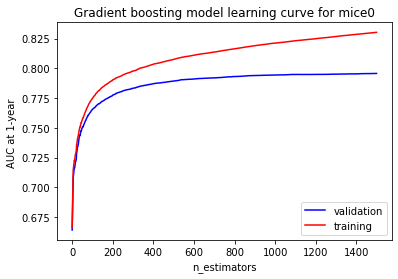

In [125]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm0_staged_auc))
plt.plot(x, gbm0_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm0_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 1-year ")
plt.title('Gradient boosting model learning curve for mice0')

plt.show()

In [126]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm0_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm0_staged_auc[x:x+24]))

In [127]:
print('Number of trees where 1 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm0_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm0_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 1 year AUC on validation dataset beings to downgrade: 1125
Validation dataset AUC before degrading: 0.7947976477376847
Training dataset AUC before degrading: 0.8235286618500477


In [128]:
print(train_mice0_x.shape)
print(train_y.shape)

(54786, 142)
(54786,)


In [129]:
gap90_IDs = pd.read_csv('gap90_IDs.csv')

In [130]:
train90 = train[train.PatientID.isin(gap90_IDs['PatientID'])]

In [131]:
train90_mice0_x = train_mice0_x[train_mice0_x.index.isin(gap90_IDs['PatientID'])]

In [132]:
train90_y = np.array([tuple(x) for x in train90[['death_status', 'timerisk_activity']].values], 
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

In [133]:
train90_mice0_x.shape

(49095, 142)

In [134]:
train90_y.shape

(49095,)

In [135]:
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 1125,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__gradientboostingsurvivalanalysis__max_depth': [2, 3, 4], 
              'estimator__gradientboostingsurvivalanalysis__subsample': [0.5, 0.75, 0.9]}

gbm_search = HalvingGridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 365),
    param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    max_resources = 30000,
    return_train_score = False,
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
gbm_search.fit(train90_mice0_x, train90_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 3750
max_resources_: 30000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 3750
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 5
n_resources: 7500
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 15000
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 30000
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('num',
                                                                                                                           Pipeline(steps=[('std_scaler',
                                                                                                                                            StandardScaler())]),
                                                                                                                           ['age',
                                                                                                 

In [136]:
gbm_search.best_params_

{'estimator__gradientboostingsurvivalanalysis__max_depth': 2,
 'estimator__gradientboostingsurvivalanalysis__subsample': 0.75}

**The above best tree depth and subsample will be used for all models moving forward mainly due to the computational cost of searching for these parameters (5-8 hours) for each MICE training set. It also seems likely that these two hyperparamters have small impact on test set AUC performance and are unlikely to change by much for each training set.** 

#### Building model and assessing performance 

In [137]:
gbm_mice0 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 1125,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 2,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice0.fit(train_mice0_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      286877.4053          32.3981          659.36m
         2      287264.9774          29.2052          660.51m
         3      287297.9251          26.5734          660.85m
         4      287093.0288          27.3690          659.19m
         5      286982.2736          24.7936          659.43m
         6      286036.3401          23.9783          659.09m
         7      286648.1824          22.1001          658.19m
         8      286283.0844          25.0695          657.33m
         9      287022.8181          22.5322          656.64m
        10      286535.7145          22.5936          656.00m
        20      285771.0338          17.4571          647.74m
        30      285677.5217          11.7102          640.29m
        40      285246.7790          14.9611          633.59m
        50      284465.6079           9.1583          627.51m
        60      283906.6150           7.6676          622.16m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [138]:
dump(gbm_mice0, 'gbm_mice0.joblib') 

['gbm_mice0.joblib']

In [139]:
gbm_risk_scores_te = gbm_mice0.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 365)[0][0]
print('Test set AUC at 1 year:', gbm_auc_te)

Test set AUC at 1 year: 0.7896375486891622


In [140]:
gbm_risk_scores_tr = gbm_mice0.predict(train_mice0_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 365)[0][0]
print('Training set AUC at 1 year:', gbm_auc_tr)

Training set AUC at 1 year: 0.8010855703952557


In [141]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 365)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [142]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0018677430449502964


In [143]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 365)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [144]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0019822478271246144


In [145]:
mice_auc_data = {'mice_dataset': ['mice_0'],
                 'auc_1yr_te': [gbm_auc_te],
                 'sem_te': [standard_error_te],
                 'auc_1yr_tr': [gbm_auc_tr],
                 'sem_tr': [standard_error_tr]}

mice_auc_df = pd.DataFrame(mice_auc_data)

In [146]:
mice_auc_df

,mice_dataset,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,mice_0,0.789638,0.001868,0.801086,0.001982


In [147]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [148]:
times = np.arange(30, 1810, 30)
mice0_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice0_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice_auc_over5 = pd.DataFrame(times_data, index = ['mice_0'])

In [149]:
mice_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.850822,0.855091,0.843149,0.835351,0.830933,0.823519,0.814783,0.806989,0.800294,0.795424,...,0.746093,0.745327,0.745611,0.744196,0.74524,0.746768,0.747993,0.747462,0.745012,0.748695


In [150]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [151]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice0_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 192
Number of non-zero features in final model: 132


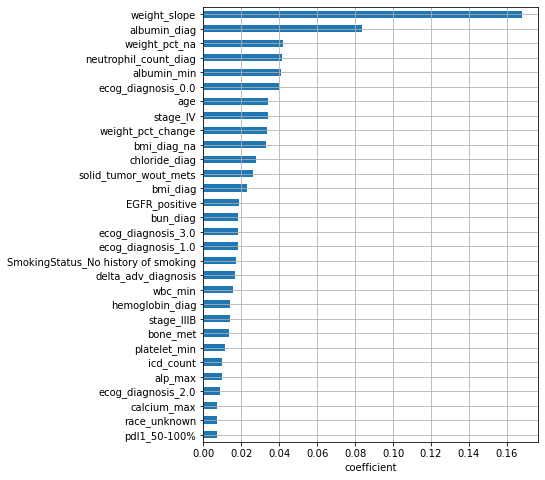

In [152]:
# Dataframe of coefficients for each variable 
coefficients_mice0 = pd.DataFrame(
    gbm_mice0.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice0.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice0.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [153]:
coefficients_mice = (
    coefficients_mice0
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [154]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.2 Model 1

#### Preprocessing and building pipeline 

In [155]:
# Import second training set
train_mice1 = pd.read_csv('mice_tr1.csv', index_col = 'PatientID')

In [156]:
print(train_mice1.shape)

(54786, 184)


In [157]:
train_mice1.isna().sum().sum()

0

In [158]:
train_mice1 = train_mice1.drop(columns = mice_drop)

In [159]:
print(train_mice1.shape)
print(test_mice.shape)

(54786, 142)
(68485, 144)


In [160]:
train_mice1['ecog_na'] = np.where(train_mice1.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice1['stage_na'] = np.where(train_mice1.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [161]:
train_mice1.ecog_na.value_counts()

1    29019
0    25767
Name: ecog_na, dtype: int64

In [162]:
for x in list(to_be_categorical):
    train_mice1[x] = train_mice1[x].astype('category')
    
list(train_mice1.select_dtypes(include = ['category']).columns)

['PracticeType',
 'gender',
 'race',
 'ethnicity',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'adv_year',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'ecog_diagnosis']

In [163]:
train_mice1['death_status'] = train_mice1['death_status'].astype('bool')

In [164]:
val_mice1 = train_mice1[train_mice1.index.isin(val_IDs['PatientID'])]

sub_train_mice1 = train_mice1[~train_mice1.index.isin(val_IDs['PatientID'])]

In [165]:
print(train_mice1.shape)
print(sub_train_mice1.shape)
print(val_mice1.shape)

(54786, 144)
(41089, 144)
(13697, 144)


In [166]:
train_mice1_x = train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice1_x = sub_train_mice1.drop(columns = ['death_status', 'timerisk_activity'])

val_mice1_x = val_mice1.drop(columns = ['death_status', 'timerisk_activity'])

In [167]:
print(train_mice1_x.shape)
print(sub_train_mice1_x.shape)
print(val_mice1_x.shape)

(54786, 142)
(41089, 142)
(13697, 142)


#### Hyperparameter tuning 

In [168]:
sub_train_mice1_xt = preprocessor_red.fit_transform(sub_train_mice1_x)
val_mice1_xt = preprocessor_red.transform(val_mice1_x)

gbm_mice1_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.1,
                                                 max_depth = 2,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice1_exp.fit(sub_train_mice1_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      209643.9721          43.3404          491.48m
         2      208067.6008          41.6231          494.28m
         3      209350.3755          39.2687          493.66m
         4      209028.8065          34.7391          493.48m
         5      208556.7180          35.0583          492.92m
         6      208478.3222          30.4664          492.20m
         7      208271.1554          27.6306          492.24m
         8      208211.8404          27.9234          491.81m
         9      208520.7825          22.7520          491.17m
        10      207614.6081          23.9606          490.72m
        20      207832.3408          15.2228          486.54m
        30      207149.9931          14.3515          483.44m
        40      206685.6485           8.8115          479.84m
        50      206115.8142           7.2536          476.40m
        60      205959.4148           7.7554          473.03m
       

GradientBoostingSurvivalAnalysis(max_depth=2, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [169]:
gbm1_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 365)[0][0] for 
                   risk_score in gbm_mice1_exp.staged_predict(val_mice1_xt)]

In [170]:
gbm1_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 365)[0][0] for 
                      risk_score in gbm_mice1_exp.staged_predict(sub_train_mice1_xt)]

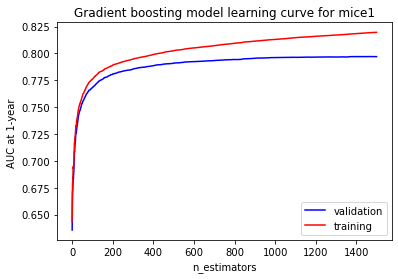

In [171]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm1_staged_auc))
plt.plot(x, gbm1_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm1_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 1-year ")
plt.title('Gradient boosting model learning curve for mice1')

plt.show()

In [172]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm1_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm1_staged_auc[x:x+24]))

In [173]:
print('Number of trees where 1 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm1_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm1_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 1 year AUC on validation dataset beings to downgrade: 1150
Validation dataset AUC before degrading: 0.7965738925352202
Training dataset AUC before degrading: 0.8152740775862752


#### Building model and assessing performance 

In [174]:
gbm_mice1 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.1,
                                                                             max_depth = 2,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice1.fit(train_mice1_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      286783.8103          62.3442          675.09m
         2      287094.4184          53.2566          675.38m
         3      287058.5114          53.0758          675.31m
         4      286779.4937          49.1291          675.74m
         5      286621.8311          42.1962          675.49m
         6      285625.9071          42.4063          675.07m
         7      286184.0105          33.8270          674.80m
         8      285796.5881          36.0509          673.99m
         9      286463.5202          42.8123          673.31m
        10      285950.3128          32.0668          672.46m
        20      284851.0819          32.2103          665.34m
        30      284556.1972          15.4246          658.95m
        40      284009.9568          12.9778          652.80m
        50      283151.5895           8.7933          646.64m
        60      282604.0444          14.7776          640.58m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [175]:
dump(gbm_mice1, 'gbm_mice1.joblib') 

['gbm_mice1.joblib']

In [176]:
gbm_risk_scores_te = gbm_mice1.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 365)[0][0]
print('Test set AUC at 1 year:', gbm_auc_te)

Test set AUC at 1 year: 0.7942907422515644


In [177]:
gbm_risk_scores_tr = gbm_mice1.predict(train_mice1_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 365)[0][0]
print('Training set AUC at 1 year:', gbm_auc_tr)

Training set AUC at 1 year: 0.8111809704861845


In [178]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 365)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [179]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0018441722370572365


In [180]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 365)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [181]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0019165180300917746


In [182]:
mice_auc_data = {'mice_dataset': 'mice_1',
                 'auc_1yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_1yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [183]:
mice_auc_df 

,mice_dataset,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,mice_0,0.789638,0.001868,0.801086,0.001982
1,mice_1,0.794291,0.001844,0.811181,0.001917


In [184]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [185]:
times = np.arange(30, 1810, 30)
mice1_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice1_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice1_auc_over5_df = pd.DataFrame(times_data, index = ['mice_1'])

mice_auc_over5 = mice_auc_over5.append(mice1_auc_over5_df, ignore_index = False)

In [186]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.850822,0.855091,0.843149,0.835351,0.830933,0.823519,0.814783,0.806989,0.800294,0.795424,...,0.746093,0.745327,0.745611,0.744196,0.74524,0.746768,0.747993,0.747462,0.745012,0.748695
mice_1,0.854577,0.863081,0.850731,0.840198,0.834523,0.827636,0.818891,0.811677,0.804942,0.800139,...,0.752351,0.751874,0.752528,0.751514,0.75264,0.753696,0.755086,0.754951,0.753021,0.756430


In [187]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [188]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice1_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 192
Number of non-zero features in final model: 163


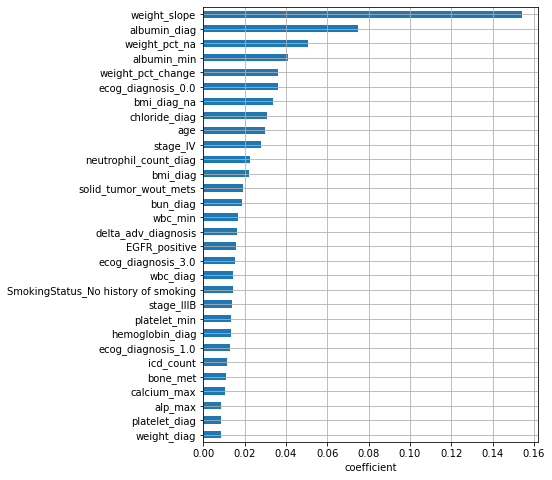

In [189]:
# Dataframe of coefficients for each variable 
coefficients_mice1 = pd.DataFrame(
    gbm_mice1.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice1.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice1.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [190]:
coefficients_mice1_df = (
    coefficients_mice1
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [191]:
coefficients_mice = coefficients_mice.append(coefficients_mice1_df, ignore_index = True)

In [192]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.3 Model 3

#### Preprocessing 

In [193]:
train_mice2 = pd.read_csv('mice_tr2.csv', index_col = 'PatientID')

In [194]:
print(train_mice2.shape)
print('Number of missing elements:', train_mice2.isna().sum().sum())

(54786, 184)
Number of missing elements: 0


In [195]:
train_mice2 = train_mice2.drop(columns = mice_drop)

In [196]:
print(train_mice2.shape)

(54786, 142)


In [197]:
train_mice2['ecog_na'] = np.where(train_mice2.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice2['stage_na'] = np.where(train_mice2.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [198]:
train_mice2.ecog_na.value_counts()

1    29019
0    25767
Name: ecog_na, dtype: int64

In [199]:
for x in list(to_be_categorical):
    train_mice2[x] = train_mice2[x].astype('category')
    
list(train_mice2.select_dtypes(include = ['category']).columns)

['PracticeType',
 'gender',
 'race',
 'ethnicity',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'adv_year',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'ecog_diagnosis']

In [200]:
train_mice2['death_status'] = train_mice2['death_status'].astype('bool')

In [201]:
val_mice2 = train_mice2[train_mice2.index.isin(val_IDs['PatientID'])]

sub_train_mice2 = train_mice2[~train_mice2.index.isin(val_IDs['PatientID'])]

In [202]:
print(train_mice2.shape)
print(sub_train_mice2.shape)
print(val_mice2.shape)

(54786, 144)
(41089, 144)
(13697, 144)


In [203]:
train_mice2_x = train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice2_x = sub_train_mice2.drop(columns = ['death_status', 'timerisk_activity'])

val_mice2_x = val_mice2.drop(columns = ['death_status', 'timerisk_activity'])

In [204]:
print(train_mice2_x.shape)
print(sub_train_mice2_x.shape)
print(val_mice2_x.shape)

(54786, 142)
(41089, 142)
(13697, 142)


#### Hyperparameter tuning 

In [205]:
sub_train_mice2_xt = preprocessor_red.fit_transform(sub_train_mice2_x)
val_mice2_xt = preprocessor_red.transform(val_mice2_x)

gbm_mice2_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.1,
                                                 max_depth = 2,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice2_exp.fit(sub_train_mice2_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      209650.9937          42.4332          497.84m
         2      208078.8973          40.6565          496.88m
         3      209362.5502          35.8434          496.56m
         4      209053.9492          31.9258          496.20m
         5      208576.2303          32.8067          495.52m
         6      208506.9560          30.2655          495.07m
         7      208306.8290          27.3210          494.71m
         8      208248.4772          27.3248          494.25m
         9      208547.7285          22.6942          493.93m
        10      207629.6458          26.5821          493.36m
        20      207875.1742          18.6753          489.71m
        30      207196.4764          11.9818          486.33m
        40      206753.3646           7.9395          483.07m
        50      206159.6692           9.0497          479.71m
        60      206001.3256           5.5369          476.33m
       

GradientBoostingSurvivalAnalysis(max_depth=2, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [206]:
gbm2_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 365)[0][0] for 
                   risk_score in gbm_mice2_exp.staged_predict(val_mice2_xt)]

In [207]:
gbm2_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 365)[0][0] for 
                      risk_score in gbm_mice2_exp.staged_predict(sub_train_mice2_xt)]

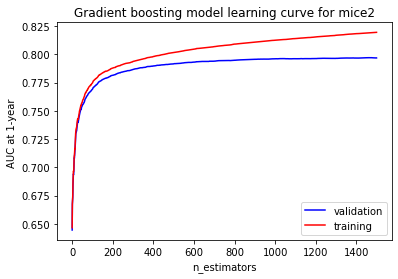

In [208]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm2_staged_auc))
plt.plot(x, gbm2_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm2_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 1-year ")
plt.title('Gradient boosting model learning curve for mice2')

plt.show()

In [209]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm2_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm2_staged_auc[x:x+24]))

In [210]:
print('Number of trees where 1 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm2_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm2_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 1 year AUC on validation dataset beings to downgrade: 1025
Validation dataset AUC before degrading: 0.796227887802414
Training dataset AUC before degrading: 0.813000088826392


#### Model building and performance assessment

In [211]:
gbm_mice2 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.1,
                                                                             max_depth = 2,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice2.fit(train_mice2_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      286790.4599          57.6982          597.43m
         2      287101.8179          52.4959          599.18m
         3      287073.2567          48.1216          599.34m
         4      286812.4202          45.9594          597.55m
         5      286641.1578          45.7015          596.25m
         6      285641.0254          40.0024          595.06m
         7      286206.0881          34.9393          594.02m
         8      285809.1844          37.2177          593.33m
         9      286509.9625          36.5228          592.47m
        10      285977.7605          35.5662          591.74m
        20      284887.2214          21.3050          585.17m
        30      284568.7671          14.4506          579.16m
        40      284032.0449          11.5581          573.52m
        50      283203.9564           9.4501          568.43m
        60      282648.3105           8.3191          563.05m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [212]:
dump(gbm_mice2, 'gbm_mice2.joblib') 

['gbm_mice2.joblib']

In [213]:
gbm_risk_scores_te = gbm_mice2.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 365)[0][0]
print('Test set AUC at 1 year:', gbm_auc_te)

Test set AUC at 1 year: 0.7935704347285975


In [214]:
gbm_risk_scores_tr = gbm_mice2.predict(train_mice2_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 365)[0][0]
print('Training set AUC at 1 year:', gbm_auc_tr)

Training set AUC at 1 year: 0.8099123098429422


In [215]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 365)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [216]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0018378211940124763


In [217]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 365)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [218]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0019488115278054154


In [219]:
mice_auc_data = {'mice_dataset': 'mice_2',
                 'auc_1yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_1yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [220]:
mice_auc_df 

,mice_dataset,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,mice_0,0.789638,0.001868,0.801086,0.001982
1,mice_1,0.794291,0.001844,0.811181,0.001917
2,mice_2,0.793570,0.001838,0.809912,0.001949


In [221]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [222]:
times = np.arange(30, 1810, 30)
mice2_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice2_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice2_auc_over5_df = pd.DataFrame(times_data, index = ['mice_2'])

mice_auc_over5 = mice_auc_over5.append(mice2_auc_over5_df, ignore_index = False)

In [223]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.850822,0.855091,0.843149,0.835351,0.830933,0.823519,0.814783,0.806989,0.800294,0.795424,...,0.746093,0.745327,0.745611,0.744196,0.745240,0.746768,0.747993,0.747462,0.745012,0.748695
mice_1,0.854577,0.863081,0.850731,0.840198,0.834523,0.827636,0.818891,0.811677,0.804942,0.800139,...,0.752351,0.751874,0.752528,0.751514,0.752640,0.753696,0.755086,0.754951,0.753021,0.756430
mice_2,0.855811,0.861520,0.849671,0.839782,0.834536,0.827288,0.818157,0.810527,0.804328,0.799488,...,0.749244,0.748524,0.749196,0.748024,0.748689,0.749904,0.751291,0.751072,0.749081,0.752291


In [224]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [225]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice2_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 192
Number of non-zero features in final model: 148


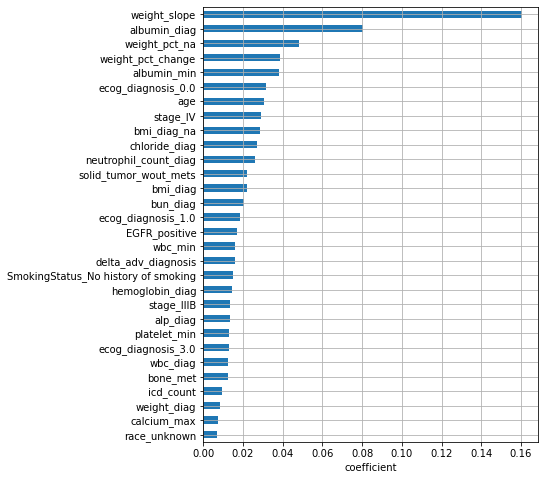

In [226]:
# Dataframe of coefficients for each variable 
coefficients_mice2 = pd.DataFrame(
    gbm_mice2.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice2.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice2.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [227]:
coefficients_mice2_df = (
    coefficients_mice2
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [228]:
coefficients_mice = coefficients_mice.append(coefficients_mice2_df, ignore_index = True)

In [229]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.4 Model 4

#### Preprocessing 

In [230]:
train_mice3 = pd.read_csv('mice_tr3.csv', index_col = 'PatientID')

In [231]:
print(train_mice3.shape)
print('Number of missing elements:', train_mice3.isna().sum().sum())

(54786, 184)
Number of missing elements: 0


In [232]:
train_mice3 = train_mice3.drop(columns = mice_drop)

In [233]:
print(train_mice3.shape)

(54786, 142)


In [234]:
train_mice3['ecog_na'] = np.where(train_mice3.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice3['stage_na'] = np.where(train_mice3.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [235]:
train_mice3.ecog_na.value_counts()

1    29019
0    25767
Name: ecog_na, dtype: int64

In [236]:
for x in list(to_be_categorical):
    train_mice3[x] = train_mice3[x].astype('category')
    
list(train_mice3.select_dtypes(include = ['category']).columns)

['PracticeType',
 'gender',
 'race',
 'ethnicity',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'adv_year',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'ecog_diagnosis']

In [237]:
train_mice3['death_status'] = train_mice3['death_status'].astype('bool')

In [238]:
val_mice3 = train_mice3[train_mice3.index.isin(val_IDs['PatientID'])]

sub_train_mice3 = train_mice3[~train_mice3.index.isin(val_IDs['PatientID'])]

In [239]:
print(train_mice3.shape)
print(sub_train_mice3.shape)
print(val_mice3.shape)

(54786, 144)
(41089, 144)
(13697, 144)


In [240]:
train_mice3_x = train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice3_x = sub_train_mice3.drop(columns = ['death_status', 'timerisk_activity'])

val_mice3_x = val_mice3.drop(columns = ['death_status', 'timerisk_activity'])

In [241]:
print(train_mice3_x.shape)
print(sub_train_mice3_x.shape)
print(val_mice3_x.shape)

(54786, 142)
(41089, 142)
(13697, 142)


#### Hyperparameter tuning 

In [242]:
sub_train_mice3_xt = preprocessor_red.fit_transform(sub_train_mice3_x)
val_mice3_xt = preprocessor_red.transform(val_mice3_x)

gbm_mice3_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.1,
                                                 max_depth = 2,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice3_exp.fit(sub_train_mice3_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      209649.3773          44.0370          495.34m
         2      208071.9760          39.4057          495.06m
         3      209359.1791          36.4816          494.93m
         4      209044.0757          34.8516          494.75m
         5      208580.2460          35.5388          494.49m
         6      208489.3065          29.1323          494.05m
         7      208298.0219          28.0530          493.46m
         8      208226.3914          27.2687          493.21m
         9      208530.6133          22.8956          492.94m
        10      207617.6998          24.3636          492.60m
        20      207883.6443          15.1122          489.64m
        30      207208.3552          16.2289          485.90m
        40      206726.7518          13.6669          481.70m
        50      206167.5255           8.3863          477.84m
        60      205988.1541           5.2694          474.18m
       

GradientBoostingSurvivalAnalysis(max_depth=2, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [243]:
gbm3_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 365)[0][0] for 
                   risk_score in gbm_mice3_exp.staged_predict(val_mice3_xt)]

In [244]:
gbm3_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 365)[0][0] for 
                      risk_score in gbm_mice3_exp.staged_predict(sub_train_mice3_xt)]

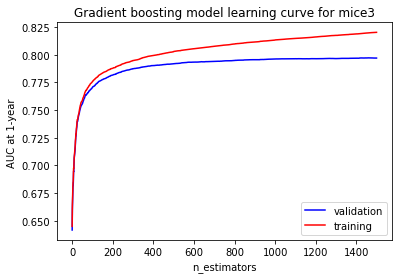

In [245]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm3_staged_auc))
plt.plot(x, gbm3_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm3_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 1-year ")
plt.title('Gradient boosting model learning curve for mice3')

plt.show()

In [246]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm3_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm3_staged_auc[x:x+24]))

In [247]:
print('Number of trees where 1 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm3_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm3_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 1 year AUC on validation dataset beings to downgrade: 875
Validation dataset AUC before degrading: 0.7955658557573515
Training dataset AUC before degrading: 0.8112855763010014


#### Model building and performance assessment 

In [248]:
gbm_mice3 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.1,
                                                                             max_depth = 2,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice3.fit(train_mice3_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      286784.6477          60.3578          511.01m
         2      287094.4311          52.8691          511.18m
         3      287058.1384          48.4007          511.02m
         4      286792.8081          45.2352          510.09m
         5      286637.9269          44.5870          509.77m
         6      285632.1163          41.7675          509.23m
         7      286193.3424          35.2925          508.71m
         8      285802.6550          38.3228          507.71m
         9      286490.3844          37.8686          507.05m
        10      285948.7537          35.6547          506.20m
        20      284857.1912          23.7173          500.87m
        30      284542.7968          14.5151          495.18m
        40      284027.1830          15.8091          489.37m
        50      283188.0461           8.2398          483.61m
        60      282646.5382           9.3889          477.77m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [249]:
dump(gbm_mice3, 'gbm_mice3.joblib') 

['gbm_mice3.joblib']

In [250]:
gbm_risk_scores_te = gbm_mice3.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 365)[0][0]
print('Test set AUC at 1 year:', gbm_auc_te)

Test set AUC at 1 year: 0.7932248361086478


In [251]:
gbm_risk_scores_tr = gbm_mice3.predict(train_mice3_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 365)[0][0]
print('Training set AUC at 1 year:', gbm_auc_tr)

Training set AUC at 1 year: 0.8085251556985835


In [252]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 365)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [253]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0018398569205063154


In [254]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 365)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [255]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0019575798926298833


In [256]:
mice_auc_data = {'mice_dataset': 'mice_3',
                 'auc_1yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_1yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [257]:
mice_auc_df 

,mice_dataset,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,mice_0,0.789638,0.001868,0.801086,0.001982
1,mice_1,0.794291,0.001844,0.811181,0.001917
2,mice_2,0.793570,0.001838,0.809912,0.001949
3,mice_3,0.793225,0.001840,0.808525,0.001958


In [258]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [259]:
times = np.arange(30, 1810, 30)
mice3_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice3_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice3_auc_over5_df = pd.DataFrame(times_data, index = ['mice_3'])

mice_auc_over5 = mice_auc_over5.append(mice3_auc_over5_df, ignore_index = False)

In [260]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.850822,0.855091,0.843149,0.835351,0.830933,0.823519,0.814783,0.806989,0.800294,0.795424,...,0.746093,0.745327,0.745611,0.744196,0.745240,0.746768,0.747993,0.747462,0.745012,0.748695
mice_1,0.854577,0.863081,0.850731,0.840198,0.834523,0.827636,0.818891,0.811677,0.804942,0.800139,...,0.752351,0.751874,0.752528,0.751514,0.752640,0.753696,0.755086,0.754951,0.753021,0.756430
mice_2,0.855811,0.861520,0.849671,0.839782,0.834536,0.827288,0.818157,0.810527,0.804328,0.799488,...,0.749244,0.748524,0.749196,0.748024,0.748689,0.749904,0.751291,0.751072,0.749081,0.752291
mice_3,0.856988,0.862535,0.849587,0.840604,0.835409,0.827747,0.818496,0.811157,0.804305,0.799510,...,0.747481,0.747018,0.747561,0.746399,0.746906,0.748466,0.750071,0.749597,0.747348,0.750310


In [261]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [262]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice3_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 192
Number of non-zero features in final model: 150


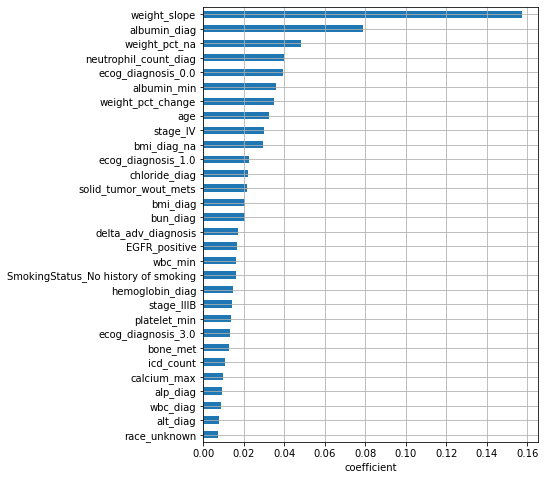

In [263]:
# Dataframe of coefficients for each variable 
coefficients_mice3 = pd.DataFrame(
    gbm_mice3.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice3.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice3.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [264]:
coefficients_mice3_df = (
    coefficients_mice3
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [265]:
coefficients_mice = coefficients_mice.append(coefficients_mice3_df, ignore_index = True)

In [266]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### 3.5 Model 5

#### Preprocessing

In [267]:
train_mice4 = pd.read_csv('mice_tr4.csv', index_col = 'PatientID')

In [268]:
print(train_mice4.shape)
print('Number of missing elements:', train_mice4.isna().sum().sum())

(54786, 184)
Number of missing elements: 0


In [269]:
train_mice4 = train_mice4.drop(columns = mice_drop)

In [270]:
print(train_mice4.shape)

(54786, 142)


In [271]:
train_mice4['ecog_na'] = np.where(train_mice4.index.isin(train.query('ecog_diagnosis == "unknown"').PatientID), 1, 0)
train_mice4['stage_na'] = np.where(train_mice4.index.isin(train.query('stage == "unknown"').PatientID), 1, 0)

In [272]:
train_mice4.ecog_na.value_counts()

1    29019
0    25767
Name: ecog_na, dtype: int64

In [273]:
for x in list(to_be_categorical):
    train_mice4[x] = train_mice4[x].astype('category')
    
list(train_mice4.select_dtypes(include = ['category']).columns)

['PracticeType',
 'gender',
 'race',
 'ethnicity',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'adv_year',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'ecog_diagnosis']

In [274]:
train_mice4['death_status'] = train_mice4['death_status'].astype('bool')

In [275]:
val_mice4 = train_mice4[train_mice4.index.isin(val_IDs['PatientID'])]

sub_train_mice4 = train_mice4[~train_mice4.index.isin(val_IDs['PatientID'])]

In [276]:
print(train_mice4.shape)
print(sub_train_mice4.shape)
print(val_mice4.shape)

(54786, 144)
(41089, 144)
(13697, 144)


In [277]:
train_mice4_x = train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

sub_train_mice4_x = sub_train_mice4.drop(columns = ['death_status', 'timerisk_activity'])

val_mice4_x = val_mice4.drop(columns = ['death_status', 'timerisk_activity'])

In [278]:
print(train_mice4_x.shape)
print(sub_train_mice4_x.shape)
print(val_mice4_x.shape)

(54786, 142)
(41089, 142)
(13697, 142)


#### Hyperparameter tuning

In [279]:
sub_train_mice4_xt = preprocessor_red.fit_transform(sub_train_mice4_x)
val_mice4_xt = preprocessor_red.transform(val_mice4_x)

gbm_mice4_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                                 learning_rate = 0.1,
                                                 max_depth = 2,
                                                 subsample = 0.75,
                                                 verbose = 1,
                                                 random_state = 42)

gbm_mice4_exp.fit(sub_train_mice4_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      209651.2981          41.1792          495.34m
         2      208079.4578          40.5800          495.40m
         3      209366.6142          35.7934          495.30m
         4      209048.2548          33.3138          495.43m
         5      208585.5737          29.6834          495.03m
         6      208503.6191          32.0780          494.67m
         7      208307.2792          30.0303          494.45m
         8      208227.8630          30.3766          494.10m
         9      208529.0062          24.9437          493.67m
        10      207606.7350          24.0723          493.25m
        20      207818.7223          18.5167          489.56m
        30      207140.7386          13.4110          486.38m
        40      206645.7864          13.8387          483.12m
        50      206089.6953           6.7423          480.02m
        60      205921.0151           6.2079          476.96m
       

GradientBoostingSurvivalAnalysis(max_depth=2, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [280]:
gbm4_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 365)[0][0] for 
                   risk_score in gbm_mice4_exp.staged_predict(val_mice4_xt)]

In [281]:
gbm4_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 365)[0][0] for 
                      risk_score in gbm_mice4_exp.staged_predict(sub_train_mice4_xt)]

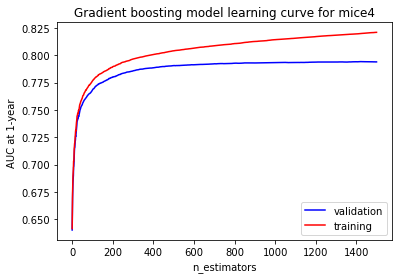

In [282]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm4_staged_auc))
plt.plot(x, gbm4_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm4_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 1-year ")
plt.title('Gradient boosting model learning curve for mice4')

plt.show()

In [283]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm4_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm4_staged_auc[x:x+24]))

In [284]:
print('Number of trees where 1 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm4_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm4_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 1 year AUC on validation dataset beings to downgrade: 725
Validation dataset AUC before degrading: 0.7924521973608043
Training dataset AUC before degrading: 0.8093735192806086


#### Model building and performance asssessment 

In [285]:
gbm_mice4 = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = np.where(np.diff(mean_auc_list) < 0)[0][0]*25,
                                                                             learning_rate = 0.1,
                                                                             max_depth = 2,
                                                                             subsample = 0.75,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_mice4.fit(train_mice4_x, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      286788.0456          59.4138          420.85m
         2      287099.6362          54.1419          420.63m
         3      287061.1060          48.6958          420.71m
         4      286800.4287          47.6881          420.09m
         5      286631.1282          47.9259          419.52m
         6      285637.3636          38.7074          419.17m
         7      286193.6979          33.7046          418.41m
         8      285800.6403          36.6317          417.98m
         9      286497.9675          36.3053          417.35m
        10      285933.8218          48.1664          416.82m
        20      284816.9116          22.7257          411.20m
        30      284514.7873          14.5039          406.13m
        40      283994.2246          14.1791          400.62m
        50      283132.9016           8.0896          395.00m
        60      282609.4772           8.6942          389.31m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'delta_adv_diagnosis',
                                                   'weight_diag', 'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope',
                                                   'albumin_diag', 'alp_diag',
                                                   'alt_diag', 'ast_diag',
                                                   'bicarb_diag', 'bun_diag',
                                                   'calcium_diag',
                                                   'chloride_diag',
           

In [286]:
dump(gbm_mice4, 'gbm_mice4.joblib') 

['gbm_mice4.joblib']

In [287]:
gbm_risk_scores_te = gbm_mice4.predict(test_mice_x)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 365)[0][0]
print('Test set AUC at 1 year:', gbm_auc_te)

Test set AUC at 1 year: 0.7915183079060135


In [288]:
gbm_risk_scores_tr = gbm_mice4.predict(train_mice4_x)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 365)[0][0]
print('Training set AUC at 1 year:', gbm_auc_tr)

Training set AUC at 1 year: 0.8050611315880992


In [289]:
# Bootstrap 10000 1 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 365)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [290]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.0018486966774581973


In [291]:
# Bootstrap 10000 1-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 365)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [292]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.001958574466924687


In [293]:
mice_auc_data = {'mice_dataset': 'mice_4',
                 'auc_1yr_te': gbm_auc_te,
                 'sem_te': standard_error_te,
                 'auc_1yr_tr': gbm_auc_tr,
                 'sem_tr': standard_error_tr}

mice_auc_df = mice_auc_df.append(mice_auc_data, ignore_index = True)

In [294]:
mice_auc_df 

,mice_dataset,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,mice_0,0.789638,0.001868,0.801086,0.001982
1,mice_1,0.794291,0.001844,0.811181,0.001917
2,mice_2,0.793570,0.001838,0.809912,0.001949
3,mice_3,0.793225,0.001840,0.808525,0.001958
4,mice_4,0.791518,0.001849,0.805061,0.001959


In [295]:
mice_auc_df.to_csv('mice_auc_df.csv', index = False, header = True)

In [296]:
times = np.arange(30, 1810, 30)
mice4_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = mice4_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
mice4_auc_over5_df = pd.DataFrame(times_data, index = ['mice_4'])

mice_auc_over5 = mice_auc_over5.append(mice4_auc_over5_df, ignore_index = False)

In [297]:
mice_auc_over5 

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
mice_0,0.850822,0.855091,0.843149,0.835351,0.830933,0.823519,0.814783,0.806989,0.800294,0.795424,...,0.746093,0.745327,0.745611,0.744196,0.745240,0.746768,0.747993,0.747462,0.745012,0.748695
mice_1,0.854577,0.863081,0.850731,0.840198,0.834523,0.827636,0.818891,0.811677,0.804942,0.800139,...,0.752351,0.751874,0.752528,0.751514,0.752640,0.753696,0.755086,0.754951,0.753021,0.756430
mice_2,0.855811,0.861520,0.849671,0.839782,0.834536,0.827288,0.818157,0.810527,0.804328,0.799488,...,0.749244,0.748524,0.749196,0.748024,0.748689,0.749904,0.751291,0.751072,0.749081,0.752291
mice_3,0.856988,0.862535,0.849587,0.840604,0.835409,0.827747,0.818496,0.811157,0.804305,0.799510,...,0.747481,0.747018,0.747561,0.746399,0.746906,0.748466,0.750071,0.749597,0.747348,0.750310
mice_4,0.852812,0.858145,0.846653,0.837810,0.832942,0.824855,0.816048,0.808819,0.802097,0.797255,...,0.747045,0.745960,0.746354,0.745231,0.746005,0.747541,0.748892,0.748094,0.746056,0.749524


In [298]:
mice_auc_over5.to_csv('mice_auc_over5.csv', index = True, header = True)

In [299]:
# Variables passing through pipeline_rsf
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_mice4_x.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 192
Number of non-zero features in final model: 137


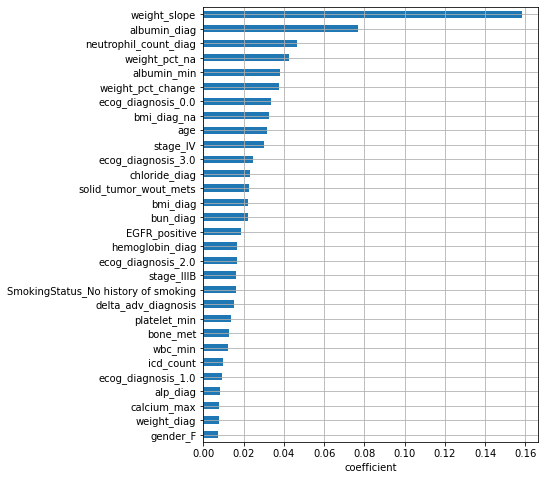

In [300]:
# Dataframe of coefficients for each variable 
coefficients_mice4 = pd.DataFrame(
    gbm_mice4.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_mice4.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_mice4.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

In [301]:
coefficients_mice4_df = (
    coefficients_mice4
    .reset_index()
    .rename(columns = {'index':'variable'}))

In [302]:
coefficients_mice = coefficients_mice.append(coefficients_mice4_df, ignore_index = True)

In [303]:
coefficients_mice.to_csv('coefficients_mice.csv', index = False, header = True)

### Part 4. Pooling results

In [304]:
from math import sqrt, exp 
from scipy.stats import t

In [305]:
# This function is translated from the R package: "psfmi: Prediction Model Selection and Performance Evaluation in
# Multiple Imputed Datasets"

def pool_auc(auc_arr, se_arr, iterations_n):
    
    # pooled SE using Rubin's rules 
    def rr_se(est, se, iterations_n):
        m = iterations_n
        w_auc = np.mean(np.square(se)) # within variance 
        b_auc = np.var(est) # between variance 
        tv_auc = w_auc + (1 + (1/m)) * b_auc # total vairance 
        se_total = sqrt(tv_auc)
        r = (1 + (1/ m)) * (b_auc / w_auc)
        v = (m - 1) * (1 + (1/r))**2
        w = t.ppf(0.975, v) # Percent point function or inverse CDF with df = v
        res = np.array([se_total, w])
        return(res)
    
    # log transform
    auc_log = np.log(auc_arr / (1-auc_arr))
    se_log = se_arr / (auc_arr * (1-auc_arr))
    
    # input log transfomred auc and se to calculat RR's total se
    se_total = rr_se(auc_log, se_log, iterations_n = iterations_n)
    
    # backtransform 
    inv_auc = exp(np.mean(auc_log)) / (1 + exp(np.mean(auc_log)))
    inv_auc_upper = exp(np.mean(auc_log) + (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) + (se_total[1]*se_total[0])))
    inv_auc_lower = exp(np.mean(auc_log) - (se_total[1]*se_total[0])) / (1 + exp(np.mean(auc_log) - (se_total[1]*se_total[0])))
    sem = (inv_auc_upper - inv_auc_lower) / 3.92
    auc_res = np.round(np.array([inv_auc_lower, inv_auc, inv_auc_upper, sem]), 6)
    return(auc_res)

In [306]:
mice_auc_df = pd.read_csv('mice_auc_df.csv', dtype = {'auc_1yr_te': np.float64,
                                                      'sem_te': np.float64,
                                                      'auc_1yr_tr': np.float64,
                                                      'sem_tr': np.float64})

In [307]:
mice_auc_df

,mice_dataset,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,mice_0,0.789638,0.001868,0.801086,0.001982
1,mice_1,0.794291,0.001844,0.811181,0.001917
2,mice_2,0.793570,0.001838,0.809912,0.001949
3,mice_3,0.793225,0.001840,0.808525,0.001958
4,mice_4,0.791518,0.001849,0.805061,0.001959


In [308]:
pool_auc_test = pool_auc(mice_auc_df['auc_1yr_te'].values, 
                         mice_auc_df['sem_te'].values, 
                         5)

print(pool_auc_test)

[0.786893 0.792453 0.797906 0.002809]


In [309]:
pool_auc_train = pool_auc(mice_auc_df['auc_1yr_tr'].values,
                          mice_auc_df['sem_tr'].values,
                          5)

print(pool_auc_train)

[0.796139 0.807179 0.817759 0.005515]


In [310]:
crude_auc_df = pd.read_csv('crude_auc_df.csv', dtype = {'auc_1yr_te': np.float64,
                                                        'sem_te': np.float64,
                                                        'auc_1yr_tr': np.float64,
                                                        'sem_tr': np.float64})

In [311]:
crude_auc_df

,model,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
0,gbm_crude,0.787443,0.004128,0.793450,0.002031
1,rsf_crude,0.774594,0.004214,0.901029,0.001352
2,ridge_crude,0.751794,0.004430,0.755288,0.002165
3,lasso_crude,0.736107,0.004536,0.737436,0.002255
4,enet_crude,0.735788,0.004540,0.737163,0.002255
5,linear_svm_crude,0.746359,0.004484,0.751083,0.002176


In [312]:
mice_auc_data = {'model': 'gbm_mice',
                 'auc_1yr_te': pool_auc_test[1],
                 'sem_te': pool_auc_test[3],
                 'auc_1yr_tr': pool_auc_train[1],
                 'sem_tr': pool_auc_train[3]}

In [313]:
ml_auc_df = crude_auc_df.append(mice_auc_data, ignore_index = True)

In [314]:
ml_auc_df.sort_values(by = 'auc_1yr_te', ascending = False)

,model,auc_1yr_te,sem_te,auc_1yr_tr,sem_tr
6,gbm_mice,0.792453,0.002809,0.807179,0.005515
0,gbm_crude,0.787443,0.004128,0.793450,0.002031
1,rsf_crude,0.774594,0.004214,0.901029,0.001352
2,ridge_crude,0.751794,0.004430,0.755288,0.002165
5,linear_svm_crude,0.746359,0.004484,0.751083,0.002176
3,lasso_crude,0.736107,0.004536,0.737436,0.002255
4,enet_crude,0.735788,0.004540,0.737163,0.002255


In [315]:
ml_auc_df.to_csv('ml_auc_df.csv', index = False, header = True)